In [45]:
import os
import math
import time
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import PatchTSTConfig, PatchTSTForPrediction  # HF time-series
# Docs for PatchTST (shapes, classes, outputs): https://huggingface.co/docs/transformers/en/model_doc/patchtst

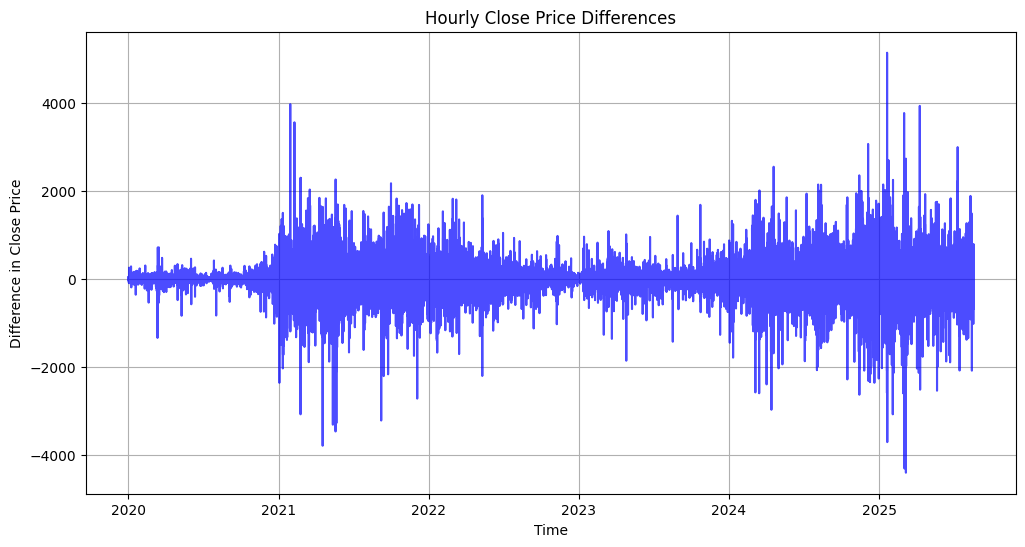

In [46]:
# Load your dataset
df = pd.read_csv("data/btc_close.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()

# 1. Compute hourly differences (newer - older)
df["close_diff"] = df["close"].diff()

# 2. Drop the first row (will be NaN after diff)
df = df.dropna()

# 3. Plot the differences
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close_diff"], color="blue", alpha=0.7)
plt.title("Hourly Close Price Differences")
plt.xlabel("Time")
plt.ylabel("Difference in Close Price")
plt.grid(True)
plt.show()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49362 entries, 2020-01-01 01:00:00+00:00 to 2025-08-18 18:00:00+00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   close       49362 non-null  float64
 1   close_diff  49362 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


In [48]:
df.tail()

,close,close_diff
timestamp,,
2025-08-18 14:00:00+00:00,115633.73,794.60
2025-08-18 15:00:00+00:00,116145.34,511.61
2025-08-18 16:00:00+00:00,115962.24,-183.10
2025-08-18 17:00:00+00:00,116428.99,466.75
2025-08-18 18:00:00+00:00,116360.97,-68.02


<Axes: xlabel='timestamp'>

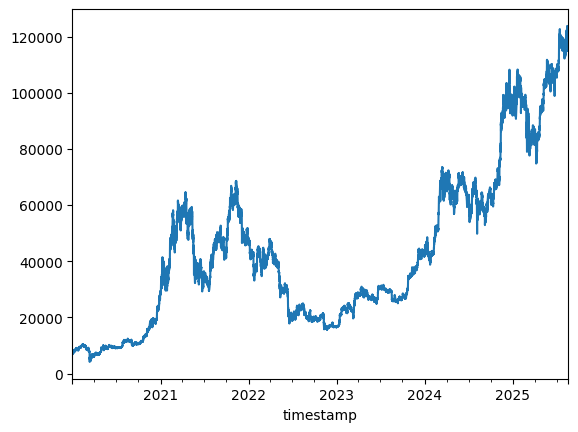

In [49]:
df['close'].plot()

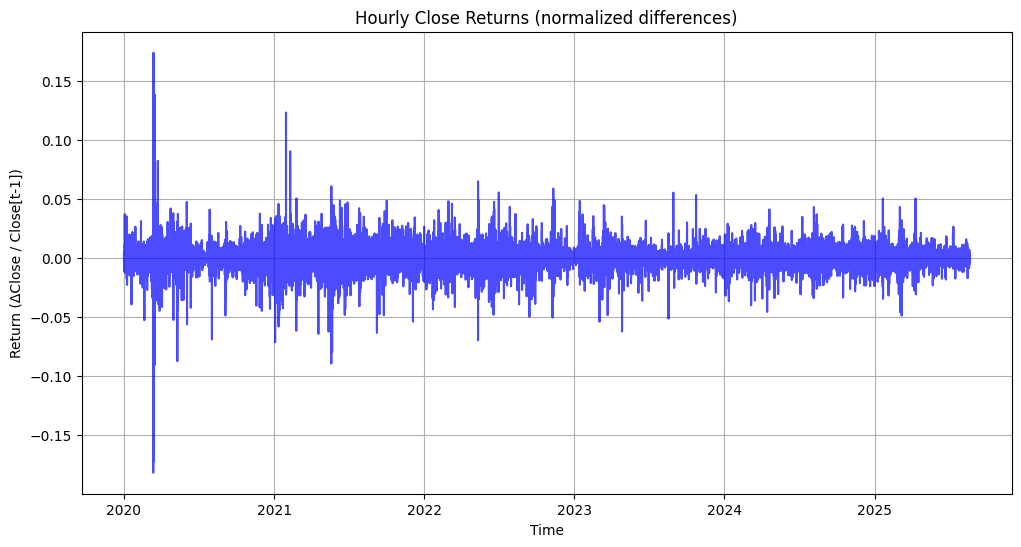

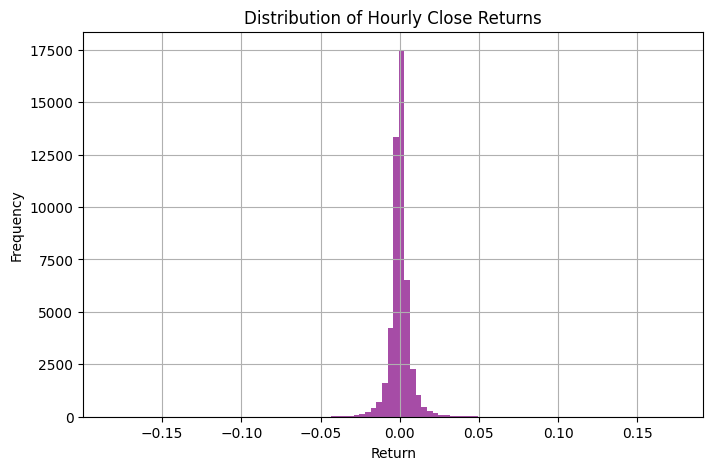

Summary statistics of returns:
count    49361.000000
mean         0.000080
std          0.006818
min         -0.182115
1%          -0.019857
5%          -0.009185
25%         -0.002348
50%          0.000067
75%          0.002558
95%          0.009437
99%          0.019500
max          0.173840
Name: close_return, dtype: float64


In [50]:
# Load your datase

# 1. Compute normalized hourly change (percentage change)
df["close_return"] = df["close"].pct_change()  # (new - old)/old

# 2. Drop NaN
df = df.dropna()

# 3. Plot the returns over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close_return"], color="blue", alpha=0.7)
plt.title("Hourly Close Returns (normalized differences)")
plt.xlabel("Time")
plt.ylabel("Return (ΔClose / Close[t-1])")
plt.grid(True)
plt.show()

# 4. Histogram of returns
plt.figure(figsize=(8, 5))
plt.hist(df["close_return"], bins=100, color="purple", alpha=0.7)
plt.title("Distribution of Hourly Close Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 5. Stats summary
print("Summary statistics of returns:")
print(df["close_return"].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

In [51]:
df.tail()

,close,close_diff,close_return
timestamp,,,
2025-08-18 14:00:00+00:00,115633.73,794.60,0.006919
2025-08-18 15:00:00+00:00,116145.34,511.61,0.004424
2025-08-18 16:00:00+00:00,115962.24,-183.10,-0.001576
2025-08-18 17:00:00+00:00,116428.99,466.75,0.004025
2025-08-18 18:00:00+00:00,116360.97,-68.02,-0.000584


In [54]:
# --- load & prep ---
df = pd.read_csv("data/btc_close.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp").set_index("timestamp").asfreq("h")
df["close"] = df["close"].ffill().bfill()

# --- target: 2h forward log return ---
H = 2
logp = np.log(df["close"])
df["fwd_ret_2h"] = logp.shift(-H) - logp  # future 2h return at time t

# --- train/val split for threshold estimation (compute thresholds on TRAIN ONLY) ---
VAL_HOURS = 24 * 30
split_time = df.index[-1] - pd.Timedelta(hours=VAL_HOURS)
train = df.loc[:split_time].copy()

# --- 5 trading strategies (crash, down, flat, up, moon) ---
r = train["fwd_ret_2h"].dropna()
q05, q35, q65, q95 = r.quantile([0.05, 0.35, 0.65, 0.95])
bins   = [-np.inf, q05, q35, q65, q95, np.inf]
labels = ["crash↓↓", "down↓", "flat", "up↑", "moon↑↑"]

# apply to full dataset
df["class"] = pd.cut(df["fwd_ret_2h"], bins=bins, labels=labels, include_lowest=True)

# inspect balance
print("Class counts:")
print(df["class"].value_counts(dropna=True).sort_index())
print("\nClass ratios (%):")
print((df["class"].value_counts(normalize=True).sort_index() * 100).round(2))

# --- numeric position sizing per class (consistent with the 5 labels) ---
ACTION_POS = {
    "crash↓↓": -1.0,   # hard short
    "down↓":   -0.5,   # short
    "flat":     0.0,   # no trade
    "up↑":      0.5,   # long
    "moon↑↑":   1.0,   # hard long
}
ACTION_NOTE = {
    "crash↓↓": "short hard",
    "down↓":   "short",
    "flat":    "no-trade",
    "up↑":     "long",
    "moon↑↑":  "long hard",
}

df["action_pos"]  = df["class"].astype("string").map(ACTION_POS)
df["action_note"] = df["class"].astype("string").map(ACTION_NOTE)

# last H rows will have NaN fwd_ret_2h (no future); keep action_* as NaN there
print("\nPreview:")
print(df[["close", "fwd_ret_2h", "class", "action_pos", "action_note"]].tail(50))

Class counts:
class
crash↓↓     2437
down↓      14810
flat       14887
up↑        14791
moon↑↑      2436
Name: count, dtype: int64

Class ratios (%):
class
crash↓↓     4.94
down↓      30.00
flat       30.16
up↑        29.96
moon↑↑      4.94
Name: proportion, dtype: float64

Preview:
                               close  fwd_ret_2h    class  action_pos  \
timestamp                                                               
2025-08-16 17:00:00+00:00  117693.00   -0.000177     flat         0.0   
2025-08-16 18:00:00+00:00  117685.79   -0.000258     flat         0.0   
2025-08-16 19:00:00+00:00  117672.12   -0.001871    down↓        -0.5   
2025-08-16 20:00:00+00:00  117655.41   -0.001657     flat         0.0   
2025-08-16 21:00:00+00:00  117452.21   -0.000609     flat         0.0   
2025-08-16 22:00:00+00:00  117460.56   -0.001750    down↓        -0.5   
2025-08-16 23:00:00+00:00  117380.66    0.000505     flat         0.0   
2025-08-17 00:00:00+00:00  117255.19    0.002987      up↑  

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49363 entries, 2020-01-01 00:00:00+00:00 to 2025-08-18 18:00:00+00:00
Freq: h
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   close        49363 non-null  float64 
 1   fwd_ret_2h   49361 non-null  float64 
 2   class        49361 non-null  category
 3   action_pos   49361 non-null  float64 
 4   action_note  49361 non-null  object  
dtypes: category(1), float64(3), object(1)
memory usage: 2.9+ MB


In [56]:
df.sample(20)

,close,fwd_ret_2h,class,action_pos,action_note
timestamp,,,,,
2024-03-14 21:00:00+00:00,71105.58,0.003977,up↑,0.5,long
2022-05-24 12:00:00+00:00,29258.03,-0.006481,down↓,-0.5,short
2020-11-08 05:00:00+00:00,15048.67,-0.007815,down↓,-0.5,short
2021-02-27 02:00:00+00:00,47375.34,0.005938,up↑,0.5,long
2021-10-20 21:00:00+00:00,65807.50,0.002942,up↑,0.5,long
2023-03-29 12:00:00+00:00,28441.77,-0.005316,down↓,-0.5,short
2020-03-03 01:00:00+00:00,8815.77,0.005749,up↑,0.5,long
2020-05-17 22:00:00+00:00,9689.31,0.009151,up↑,0.5,long
2022-02-14 18:00:00+00:00,42233.91,-0.001265,flat,0.0,no-trade


In [60]:
df['class'].describe()

count     49361
unique        5
top        flat
freq      14887
Name: class, dtype: object